# Taller de Clasificación de Imágenes

## Objetivos:
1. Realizar exploración de conjunto de datos
2. Extraer características usando modelo pre-entrenado (ResNet50, MobileNet)
3. Entrenar cabeza de clasificación (AutoGluon)
4. Evaluar desempeño de modelo

## Dataset: LabelMe-12-50k
- Web: https://www.ais.uni-bonn.de/download/datasets.html
- Download: https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz


In [1]:
#pip install autogluon

In [2]:
#!tar -xvzf LabelMe-12-50k.tar.gz

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter, defaultdict
import cv2
from pathlib import Path


from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Configurar matplotlib para mejor visualización
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")


# 1. Cargar dataset y exploración

In [4]:
dataset_path = "." 

In [5]:
# Función para cargar el dataset LabelMe-12-50k
def load_labelme_dataset(dataset_path):
    """
    Carga el dataset LabelMe-12-50k con el formato correcto de anotaciones
    Formato: filename + 12 valores float (uno por cada clase)
    Valores: -1.0 (no presente), 0.0-1.0 (parcialmente presente), 1.0 (centrado)
    """
    # Definir las 12 clases del dataset según la documentación
    class_names = [
        'person', 'car', 'building', 'window', 'tree', 'sign',
        'door', 'bookshelf', 'chair', 'table', 'keyboard', 'head'
    ]
    
    data_info = []
    class_counts = Counter()
    image_sizes = []
    clutter_count = 0
    centered_objects = 0

    
    # Procesar tanto train como test
    for split in ["train", "test"]:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            continue
            
        print(f"Procesando {split}...")
        
        # Buscar archivo de anotación principal
        annotation_file = os.path.join(split_path, "annotation.txt")
        
        if os.path.exists(annotation_file):
            try:
                # Leer archivo de anotación
                with open(annotation_file, 'r') as f:
                    lines = f.readlines()
                
                print(f"  Encontradas {len(lines)} líneas de anotación")
                
                # Procesar cada línea de anotación
                for i, line in enumerate(lines):
                    parts = line.strip().split()
                    if len(parts) >= 13:  # filename + 12 valores de clase
                        filename = parts[0]
                        labels = [float(x) for x in parts[1:13]]
                        
                        # Ruta de la imagen
                        image_path = os.path.join(split_path,"0" + filename[0:3], filename + ".jpg")
                        
                        # Verificar si la imagen existe
                        if os.path.exists(image_path):
                            try:
                                with Image.open(image_path) as img:
                                    width, height = img.size
                                    image_sizes.append((width, height))
                            except:
                                continue
                        
                        # Analizar las etiquetas
                        max_label = max(labels)
                        max_label_idx = labels.index(max_label)
                        
                        # Determinar si es clutter o objeto centrado
                        if max_label == 1.0:
                            # Objeto centrado
                            class_name = class_names[max_label_idx]
                            class_counts[class_name] += 1
                            centered_objects += 1
                        else:
                            # Clutter o objeto parcialmente visible
                            clutter_count += 1
                            class_name = "clutter"
                            class_counts["clutter"] += 1
                        
                        # Contar objetos parcialmente visibles
                        for j, label in enumerate(labels):
                            if label > 0.0 and label < 1.0:
                                class_counts[f"{class_names[j]}_partial"] += 1
                        
                        # Agregar información del dato
                        data_info.append({
                            'split': split,
                            'filename': filename,
                            'image_path': image_path,
                            'class': class_name,
                            'labels': labels,
                            'max_label': max_label,
                            'max_label_idx': max_label_idx,
                            'is_centered': max_label == 1.0,
                            'is_clutter': max_label != 1.0
                        })
                            
            except Exception as e:
                print(f"Error procesando {annotation_file}: {e}")
                continue
        else:
            print(f"  Archivo de anotación no encontrado: {annotation_file}")
    
    return data_info, class_counts, image_sizes, clutter_count, centered_objects

print("🔄 Cargando dataset LabelMe-12-50k (formato corregido)...")
data_info, class_counts, image_sizes, clutter_count, centered_objects = load_labelme_dataset(dataset_path)
print(f"✅ Dataset cargado: {len(data_info)} imágenes procesadas")
print(f"   - {len(class_counts)} categorías únicas")
print(f"   - {len(image_sizes)} imágenes analizadas")
print(f"   - {centered_objects} objetos centrados")
print(f"   - {clutter_count} imágenes clutter")

🔄 Cargando dataset LabelMe-12-50k (formato corregido)...
Procesando train...
  Encontradas 40000 líneas de anotación
Procesando test...
  Encontradas 10000 líneas de anotación
✅ Dataset cargado: 50000 imágenes procesadas
   - 25 categorías únicas
   - 50000 imágenes analizadas
   - 25000 objetos centrados
   - 25000 imágenes clutter


In [6]:
df_info = pd.DataFrame(data_info)
df_info

split filename               image_path     class  \
0      train   000000  ./train/0000/000000.jpg      tree   
1      train   000001  ./train/0000/000001.jpg       car   
2      train   000002  ./train/0000/000002.jpg  building   
3      train   000003  ./train/0000/000003.jpg       car   
4      train   000004  ./train/0000/000004.jpg       car   
...      ...      ...                      ...       ...   
49995   test   009995   ./test/0009/009995.jpg   clutter   
49996   test   009996   ./test/0009/009996.jpg       car   
49997   test   009997   ./test/0009/009997.jpg  building   
49998   test   009998   ./test/0009/009998.jpg   clutter   
49999   test   009999   ./test/0009/009999.jpg      tree   

                                                  labels  max_label  \
0      [-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0...        1.0   
1      [-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
2      [-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
3      [-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
4      [-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
...                                                  ...        ...   
49995  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....       -1.0   
49996  [-1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
49997  [-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0...        1.0   
49998  [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....       -1.0   
49999  [-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0...        1.0   

       max_label_idx  is_centered  is_clutter  
0                  4         True       False  
1                  1         True       False  
2                  2         True       False  
3                  1         True       False  
4                  1         True       False  
...              ...          ...         ...  
49995              0        False        True  
49996              1         True       False  
49997              2         True       False  
49998              0        False        True  
49999              4         True       False  

[50000 rows x 9 columns]

In [7]:
# 1.1 Análisis de distribución de clases usando DataFrame

# Análisis de distribución de clases
class_distribution = df_info['class'].value_counts()
print(f"\n📊 DISTRIBUCIÓN DE CLASES:")
print(f"  • Número de clases únicas: {len(class_distribution)}")
print(f"  • Clases principales:")
for i, (class_name, count) in enumerate(class_distribution.items(), 1):
    percentage = (count / len(df_info)) * 100
    print(f"    {i:2d}. {class_name:<15} {count:>6} imágenes ({percentage:5.1f}%)")

# Análisis de objetos centrados vs clutter
centered_count = df_info['is_centered'].sum()
clutter_count = df_info['is_clutter'].sum()
print(f"\n🎯 OBJETOS CENTRADOS VS CLUTTER:")
print(f"  • Objetos centrados: {centered_count:,} ({centered_count/len(df_info)*100:.1f}%)")
print(f"  • Imágenes clutter: {clutter_count:,} ({clutter_count/len(df_info)*100:.1f}%)")

# Análisis por split
split_distribution = df_info['split'].value_counts()
print(f"\n📁 DISTRIBUCIÓN POR SPLIT:")
for split, count in split_distribution.items():
    percentage = (count / len(df_info)) * 100
    print(f"  • {split.capitalize()}: {count:,} imágenes ({percentage:.1f}%)")



📊 DISTRIBUCIÓN DE CLASES:
  • Número de clases únicas: 13
  • Clases principales:
     1. clutter          25000 imágenes ( 50.0%)
     2. person            6036 imágenes ( 12.1%)
     3. window            5126 imágenes ( 10.3%)
     4. car               4804 imágenes (  9.6%)
     5. building          2616 imágenes (  5.2%)
     6. tree              2340 imágenes (  4.7%)
     7. sign              1200 imágenes (  2.4%)
     8. door              1008 imágenes (  2.0%)
     9. bookshelf          491 imágenes (  1.0%)
    10. chair              473 imágenes (  0.9%)
    11. keyboard           399 imágenes (  0.8%)
    12. head               261 imágenes (  0.5%)
    13. table              246 imágenes (  0.5%)

🎯 OBJETOS CENTRADOS VS CLUTTER:
  • Objetos centrados: 25,000 (50.0%)
  • Imágenes clutter: 25,000 (50.0%)

📁 DISTRIBUCIÓN POR SPLIT:
  • Train: 40,000 imágenes (80.0%)
  • Test: 10,000 imágenes (20.0%)


📊 DISTRIBUCIÓN DE CLASES - LabelMe-12-50k (4 gráficos mejorados)


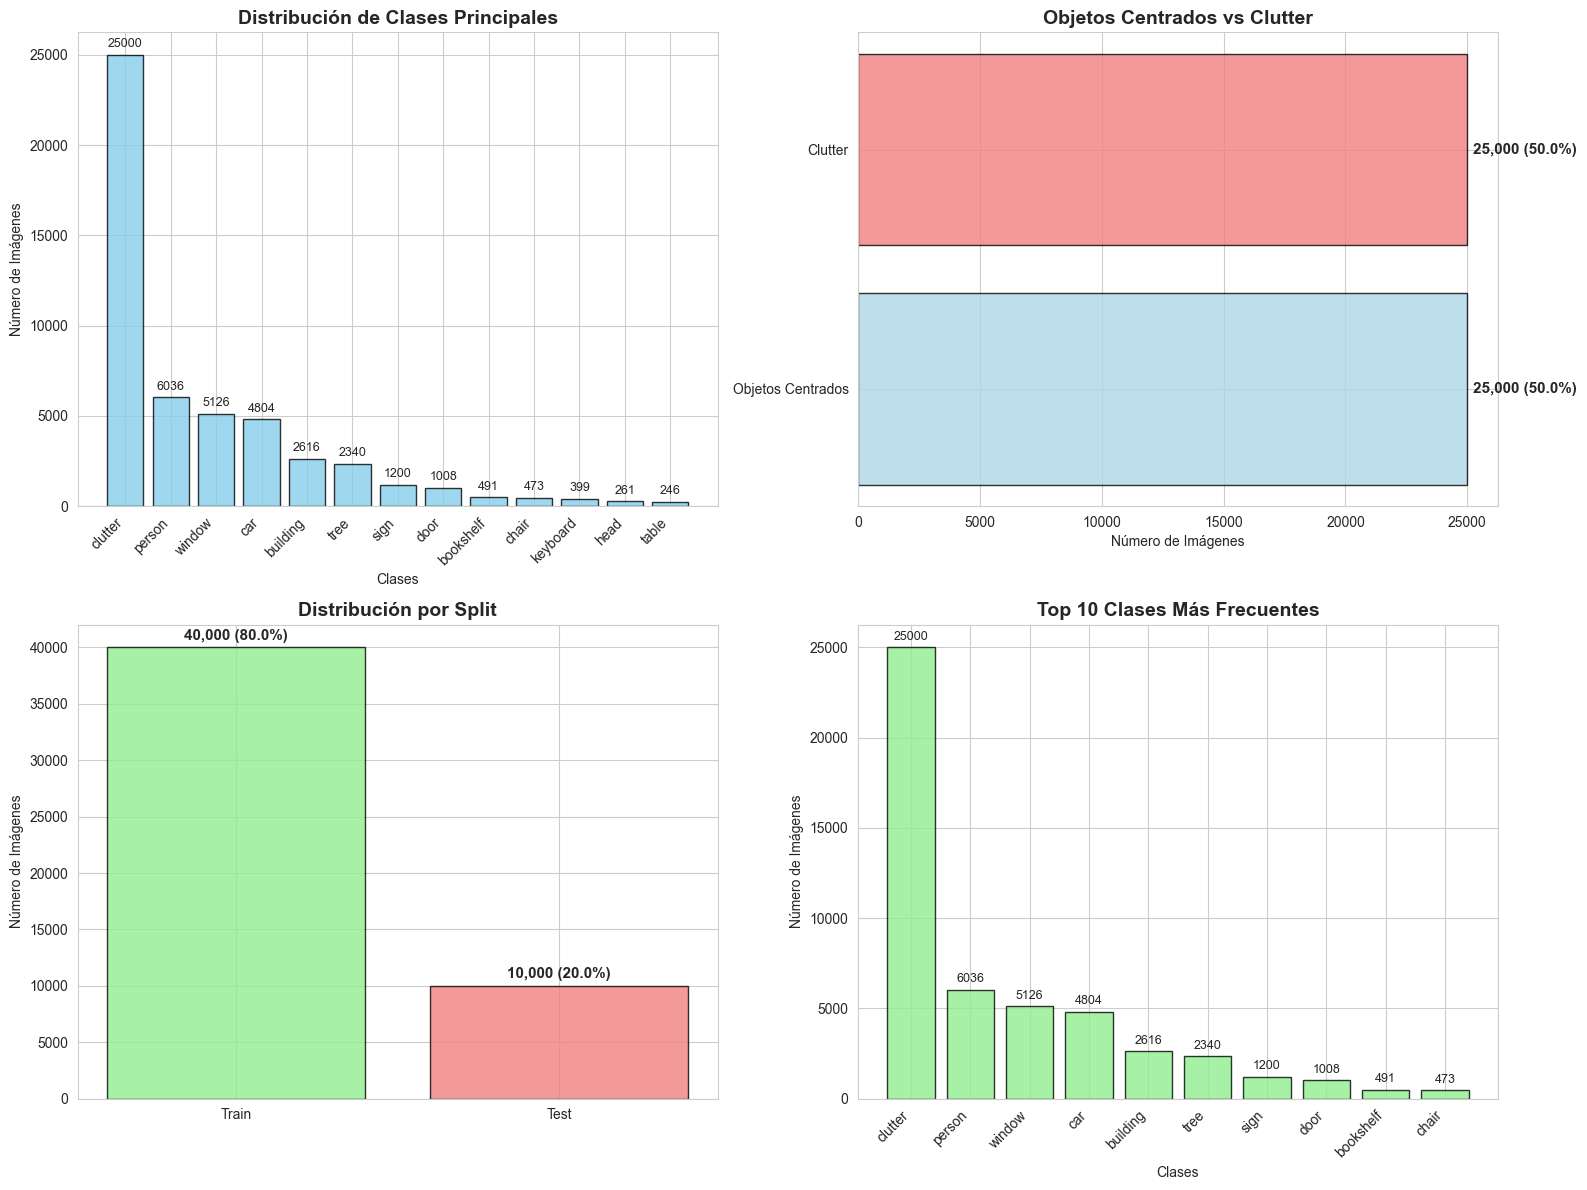


📈 ANÁLISIS DE BALANCE DEL DATASET
Coeficiente de variación (sin clutter): 0.97
✅ Dataset relativamente balanceado

Clase más frecuente: clutter (25000 imágenes)
Clase menos frecuente: table (246 imágenes)

🏷️  ANÁLISIS DE VALORES DE ETIQUETA:
  • Valores únicos: 88
  • Rango: -1.00 a 1.00
  • Etiquetas centradas (1.0): 25,003
  • Etiquetas ausentes (-1.0): 572,058
  • Etiquetas parciales (0.0 < x < 1.0): 2,887


In [8]:
# 1.1 Análisis de distribución de clases - 4 gráficos mejorados
print("📊 DISTRIBUCIÓN DE CLASES - LabelMe-12-50k (4 gráficos mejorados)")
print("=" * 70)

# Crear visualizaciones (4 gráficos en lugar de 6)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de clases principales
axes[0, 0].bar(range(len(class_distribution)), class_distribution.values, 
               color='skyblue', edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Distribución de Clases Principales', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Clases')
axes[0, 0].set_ylabel('Número de Imágenes')
axes[0, 0].set_xticks(range(len(class_distribution)))
axes[0, 0].set_xticklabels(class_distribution.index, rotation=45, ha='right')
# Agregar valores en las barras
for i, v in enumerate(class_distribution.values):
    axes[0, 0].text(i, v + max(class_distribution.values)*0.01, str(v), 
                    ha='center', va='bottom', fontsize=9)

# 2. Objetos centrados vs Clutter (gráfico de barras horizontal en lugar de pie)
categories = ['Objetos Centrados', 'Clutter']
counts = [centered_count, clutter_count]
colors = ['lightblue', 'lightcoral']
bars = axes[0, 1].barh(categories, counts, color=colors, edgecolor='black', alpha=0.8)
axes[0, 1].set_title('Objetos Centrados vs Clutter', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Número de Imágenes')
# Agregar valores en las barras
for i, v in enumerate(counts):
    axes[0, 1].text(v + max(counts)*0.01, i, f'{v:,} ({v/sum(counts)*100:.1f}%)', 
                    va='center', ha='left', fontsize=11, fontweight='bold')

# 3. Distribución por split (gráfico de barras en lugar de pie)
splits = ['Train', 'Test']
split_counts = [split_distribution['train'], split_distribution['test']]
colors_split = ['lightgreen', 'lightcoral']
bars = axes[1, 0].bar(splits, split_counts, color=colors_split, edgecolor='black', alpha=0.8)
axes[1, 0].set_title('Distribución por Split', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Número de Imágenes')
# Agregar valores en las barras
for bar, count in zip(bars, split_counts):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(split_counts)*0.01,
                    f'{count:,} ({count/sum(split_counts)*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Top 10 clases más frecuentes
top_10_classes = class_distribution.head(10)
bars = axes[1, 1].bar(range(len(top_10_classes)), top_10_classes.values, 
                      color='lightgreen', edgecolor='black', alpha=0.8)
axes[1, 1].set_title('Top 10 Clases Más Frecuentes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Clases')
axes[1, 1].set_ylabel('Número de Imágenes')
axes[1, 1].set_xticks(range(len(top_10_classes)))
axes[1, 1].set_xticklabels(top_10_classes.index, rotation=45, ha='right')
# Agregar valores en las barras
for i, v in enumerate(top_10_classes.values):
    axes[1, 1].text(i, v + max(top_10_classes.values)*0.01, str(v), 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Análisis de balance del dataset
print("\n📈 ANÁLISIS DE BALANCE DEL DATASET")
print("=" * 50)

# Calcular balance solo para clases principales (sin clutter)
main_classes = class_distribution[class_distribution.index != 'clutter']
if len(main_classes) > 0:
    cv = np.std(main_classes.values) / np.mean(main_classes.values)
    print(f"Coeficiente de variación (sin clutter): {cv:.2f}")
    
    if cv > 1.0:
        print("⚠️  Dataset desbalanceado (CV > 1.0)")
    else:
        print("✅ Dataset relativamente balanceado")

# Estadísticas adicionales
print(f"\nClase más frecuente: {class_distribution.index[0]} ({class_distribution.iloc[0]} imágenes)")
print(f"Clase menos frecuente: {class_distribution.index[-1]} ({class_distribution.iloc[-1]} imágenes)")

# Análisis de valores de etiqueta
print(f"\n🏷️  ANÁLISIS DE VALORES DE ETIQUETA:")
all_labels = []
for labels in df_info['labels']:
    all_labels.extend(labels)

all_labels = np.array(all_labels)
print(f"  • Valores únicos: {len(np.unique(all_labels))}")
print(f"  • Rango: {np.min(all_labels):.2f} a {np.max(all_labels):.2f}")
print(f"  • Etiquetas centradas (1.0): {np.sum(all_labels == 1.0):,}")
print(f"  • Etiquetas ausentes (-1.0): {np.sum(all_labels == -1.0):,}")
print(f"  • Etiquetas parciales (0.0 < x < 1.0): {np.sum((all_labels > 0.0) & (all_labels < 1.0)):,}")


🖼️  CREANDO MOSAICO DE IMÁGENES REPRESENTATIVAS
Clases seleccionadas: ['clutter', 'person', 'window', 'car', 'building', 'tree', 'sign', 'door', 'bookshelf', 'chair', 'keyboard', 'head']


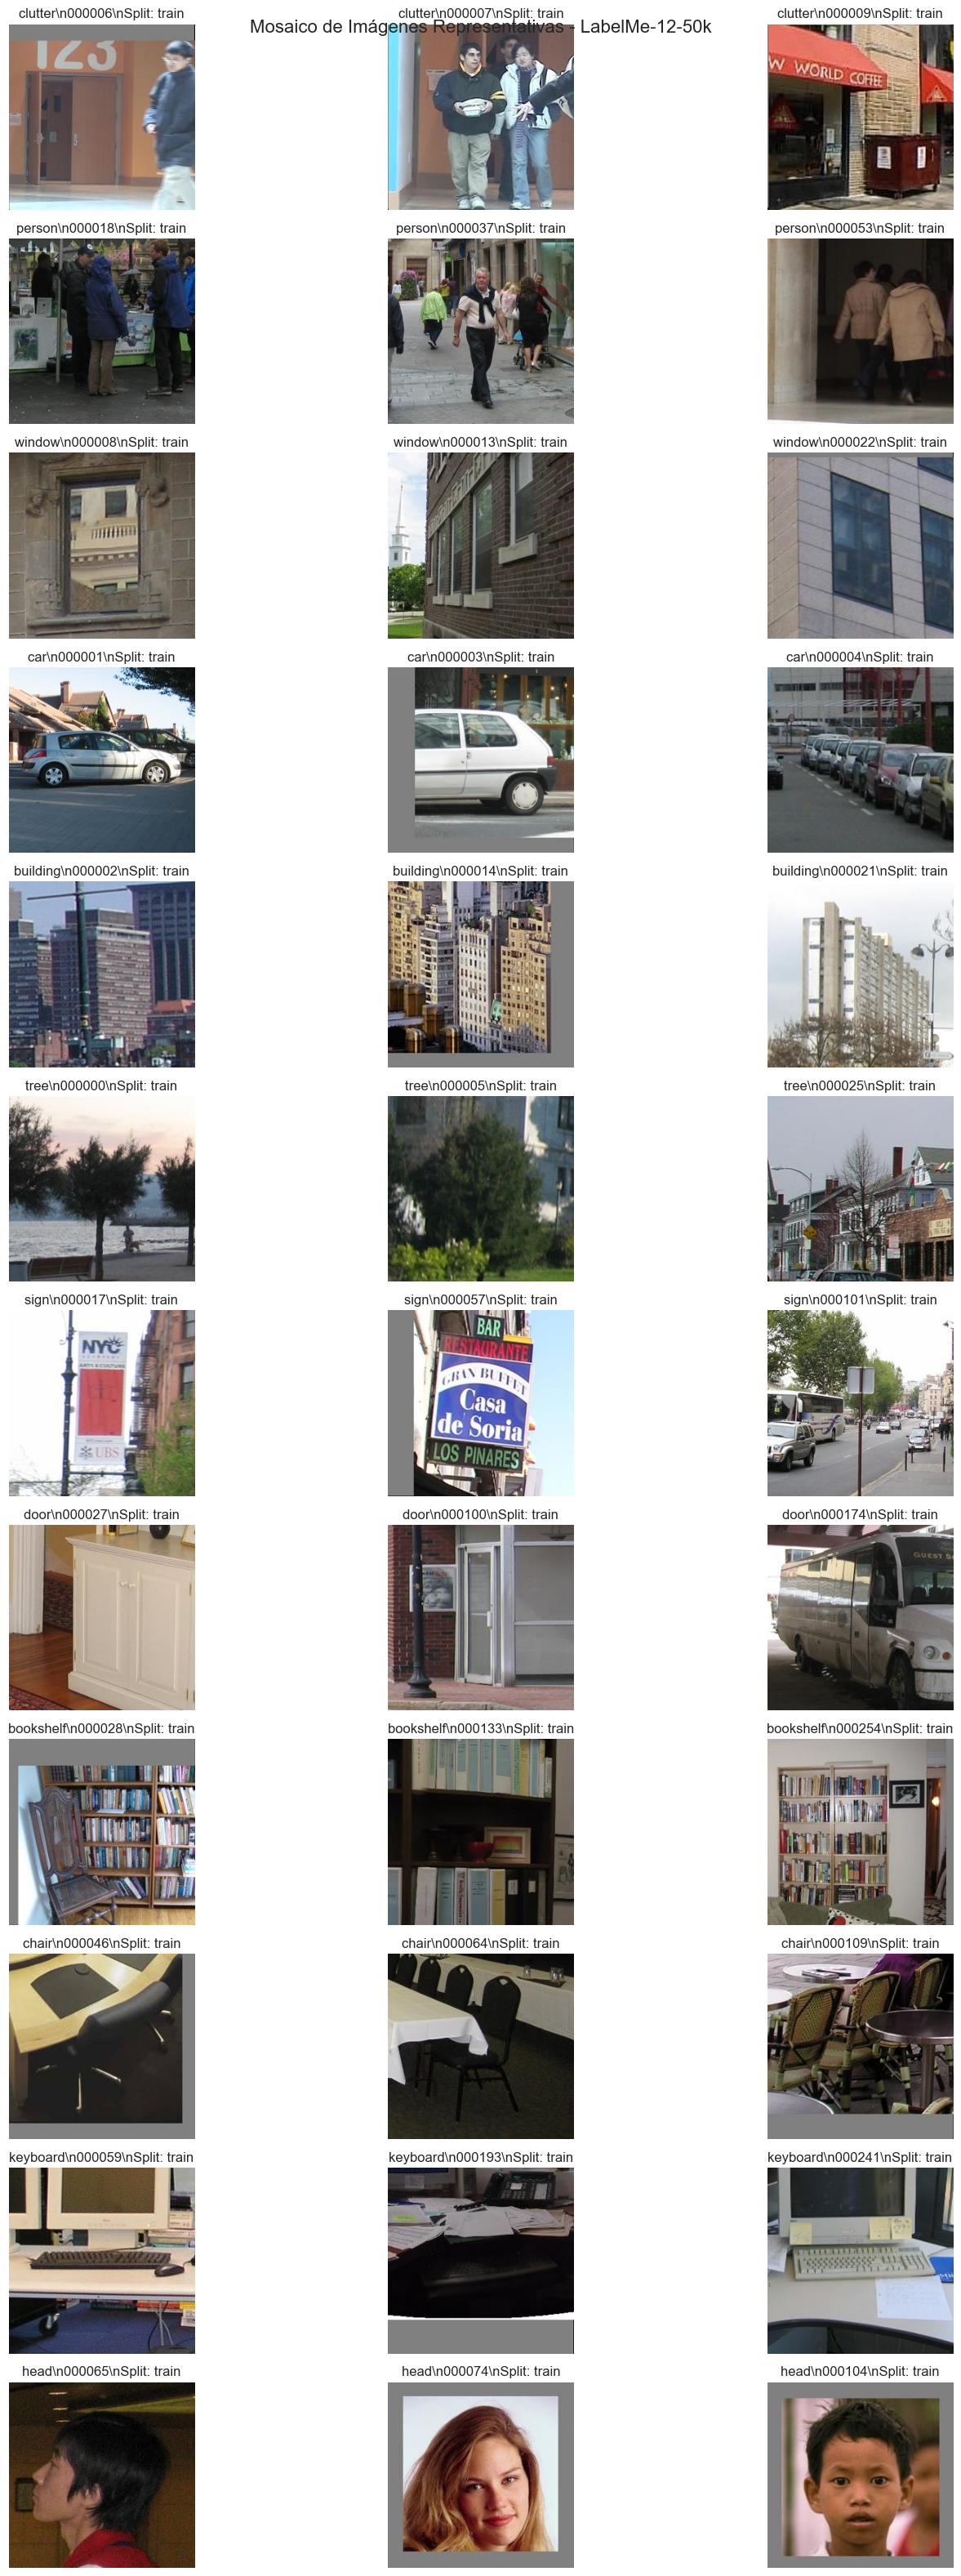

In [9]:
# 1.2 Mosaico de imágenes representativas usando DataFrame
def create_labelme_mosaic_from_df(df_info, num_images_per_class=3, max_classes=12):
    """
    Crea un mosaico de imágenes representativas usando el DataFrame
    """
    print("🖼️  CREANDO MOSAICO DE IMÁGENES REPRESENTATIVAS")
    print("=" * 55)
    
    # Obtener clases principales (sin clutter)
    main_classes = df_info['class'].value_counts()
    #main_classes = df_info[df_info['class'] != 'clutter']['class'].value_counts()
    selected_classes = main_classes.head(max_classes).index.tolist()
    
    print(f"Clases seleccionadas: {selected_classes}")
    
    # Crear figura
    fig, axes = plt.subplots(max_classes, num_images_per_class, figsize=(16, 32))
    if max_classes == 1:
        axes = axes.reshape(1, -1)
    
    for class_idx, class_name in enumerate(selected_classes):
        # Obtener imágenes de esta clase
        class_images = df_info[df_info['class'] == class_name].head(num_images_per_class)
        
        for img_idx in range(num_images_per_class):
            ax = axes[class_idx, img_idx]
            
            if img_idx < len(class_images):
                # Obtener información de la imagen
                img_info = class_images.iloc[img_idx]
                image_path = img_info['image_path']
                
                # Verificar si la imagen existe
                if os.path.exists(image_path):
                    # Cargar y mostrar imagen
                    img = Image.open(image_path)
                    ax.imshow(img)
                    
                    # Mostrar información adicional
                    title = f'{class_name}\\n{img_info["filename"]}\\nSplit: {img_info["split"]}'
                    ax.set_title(title, fontsize=12)

            
            ax.axis('off')
    
    plt.suptitle('Mosaico de Imágenes Representativas - LabelMe-12-50k', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Crear el mosaico
create_labelme_mosaic_from_df(df_info)


🖼️  ANÁLISIS DE CARACTERÍSTICAS DE IMÁGENES
📐 CARACTERÍSTICAS DE RESOLUCIÓN:
  • Resolución de las imágenes: 256x256 píxeles
  • Consistencia de resolución: 1 resoluciones únicas
  • Área por imagen: 65,536 píxeles²

📊 ANÁLISIS POR SPLIT:
  • Train: 40,000 imágenes
    - Objetos centrados: 20,000
    - Clutter: 20,000
  • Test: 10,000 imágenes
    - Objetos centrados: 5,000
    - Clutter: 5,000

🏷️  DISTRIBUCIÓN DE CLASES POR SPLIT:
  Train:
    clutter: 20000
    person: 4856
    window: 4098
    car: 3830
    building: 2085
  Test:
    clutter: 5000
    person: 1180
    window: 1028
    car: 974
    building: 531


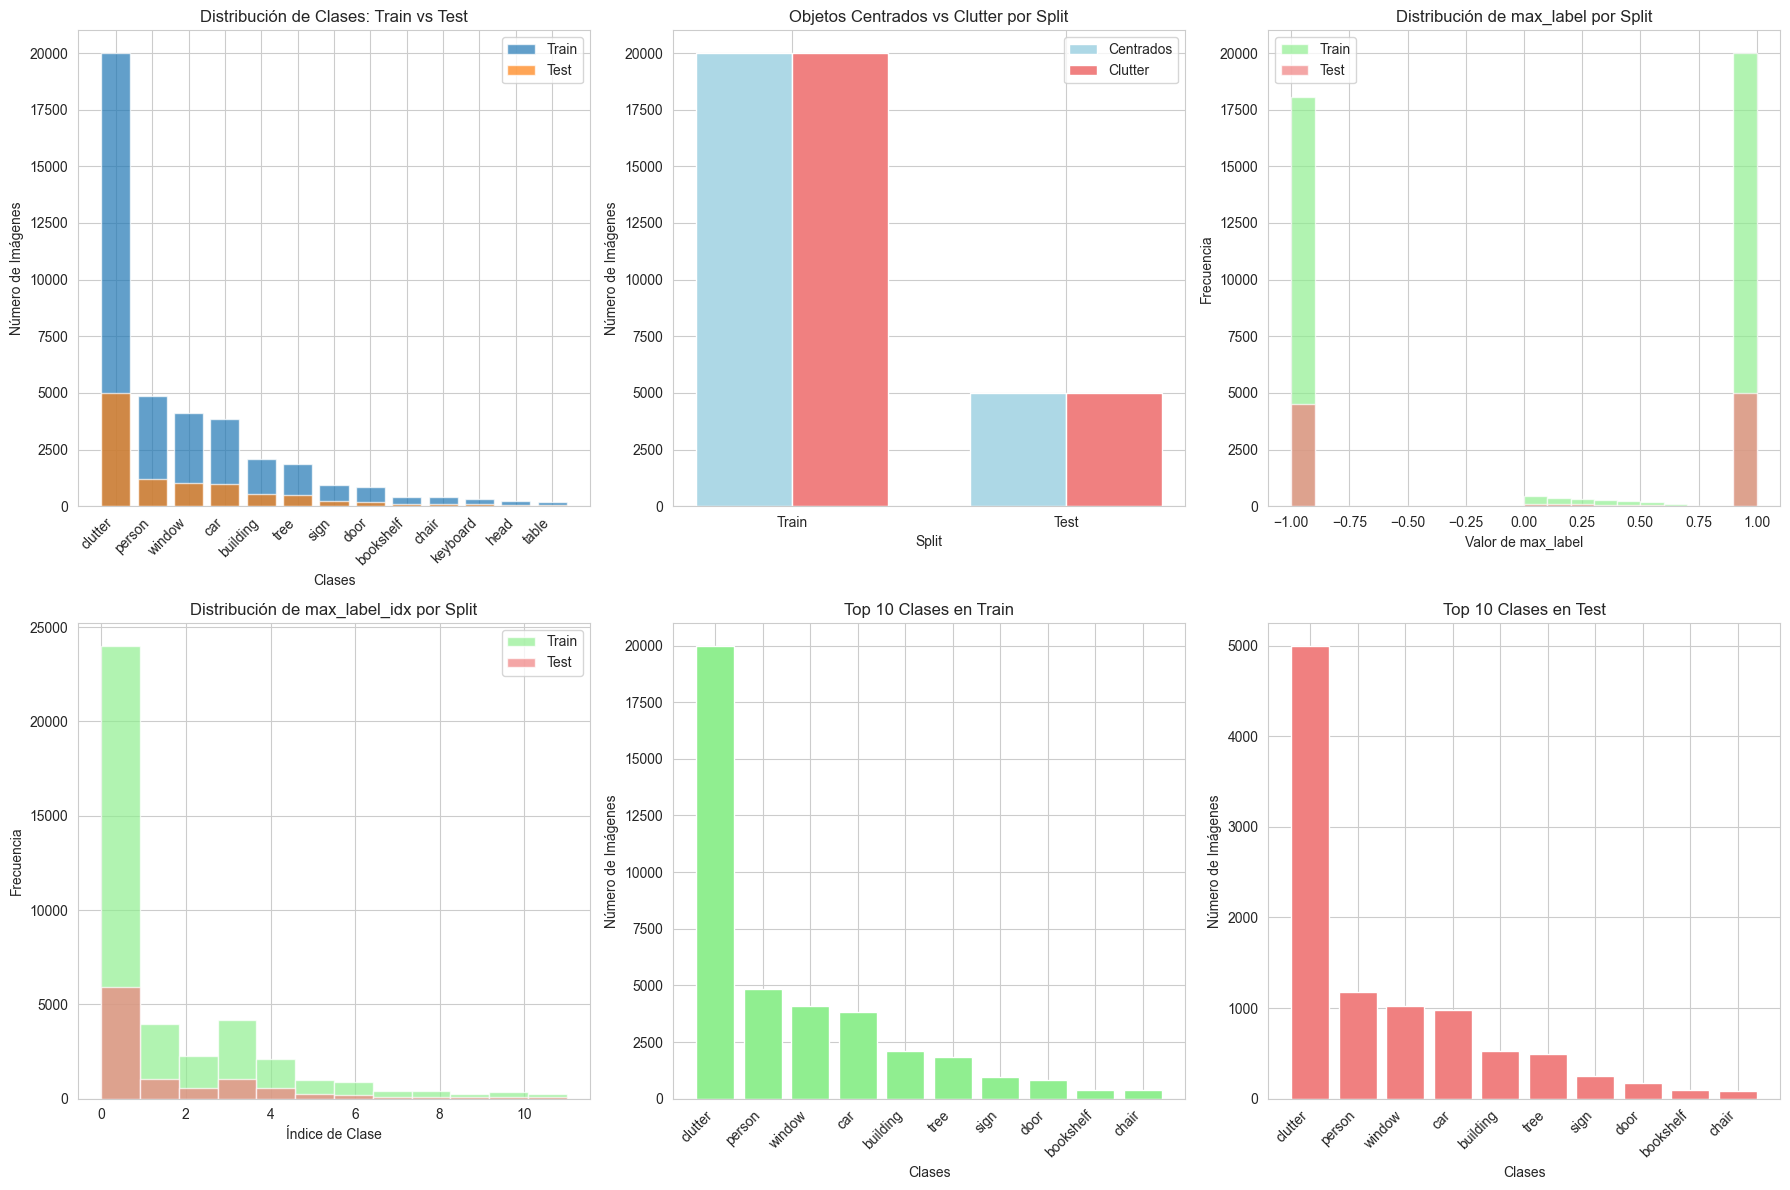


📈 ANÁLISIS DE CONSISTENCIA:
  • Clases comunes: 13
  • Clases solo en train: 0
  • Clases solo en test: 0

  Ratios Train/Test para clases principales:
    car: 3830/974 = 3.93
    keyboard: 324/75 = 4.32
    window: 4098/1028 = 3.99
    clutter: 20000/5000 = 4.00
    person: 4856/1180 = 4.12


In [10]:
# 1.4 Análisis de características de las imágenes usando DataFrame
print("🖼️  ANÁLISIS DE CARACTERÍSTICAS DE IMÁGENES")
print("=" * 50)

# Verificar algunas imágenes para obtener información de resolución
sample_images = df_info.head(10)
image_sizes = []

for idx, row in sample_images.iterrows():
    try:
        if os.path.exists(row['image_path']):
            with Image.open(row['image_path']) as img:
                width, height = img.size
                image_sizes.append((width, height))
    except:
        continue

if image_sizes:
    widths = np.array([size[0] for size in image_sizes])
    heights = np.array([size[1] for size in image_sizes])
    
    print(f"📐 CARACTERÍSTICAS DE RESOLUCIÓN:")
    print(f"  • Resolución de las imágenes: {widths[0]}x{heights[0]} píxeles")
    print(f"  • Consistencia de resolución: {len(set(zip(widths, heights)))} resoluciones únicas")
    print(f"  • Área por imagen: {widths[0] * heights[0]:,} píxeles²")

# Análisis de distribución de etiquetas por split
print(f"\n📊 ANÁLISIS POR SPLIT:")
train_df = df_info[df_info['split'] == 'train']
test_df = df_info[df_info['split'] == 'test']

print(f"  • Train: {len(train_df):,} imágenes")
print(f"    - Objetos centrados: {train_df['is_centered'].sum():,}")
print(f"    - Clutter: {train_df['is_clutter'].sum():,}")
print(f"  • Test: {len(test_df):,} imágenes")
print(f"    - Objetos centrados: {test_df['is_centered'].sum():,}")
print(f"    - Clutter: {test_df['is_clutter'].sum():,}")

# Análisis de distribución de clases por split
print(f"\n🏷️  DISTRIBUCIÓN DE CLASES POR SPLIT:")
train_classes = train_df['class'].value_counts()
test_classes = test_df['class'].value_counts()

print("  Train:")
for class_name, count in train_classes.head(5).items():
    print(f"    {class_name}: {count}")
print("  Test:")
for class_name, count in test_classes.head(5).items():
    print(f"    {class_name}: {count}")

# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribución de clases en train vs test
axes[0, 0].bar(range(len(train_classes)), train_classes.values, alpha=0.7, label='Train')
axes[0, 0].bar(range(len(test_classes)), test_classes.values, alpha=0.7, label='Test')
axes[0, 0].set_title('Distribución de Clases: Train vs Test')
axes[0, 0].set_xlabel('Clases')
axes[0, 0].set_ylabel('Número de Imágenes')
axes[0, 0].set_xticks(range(len(train_classes)))
axes[0, 0].set_xticklabels(train_classes.index, rotation=45, ha='right')
axes[0, 0].legend()

# 2. Proporción de objetos centrados por split
centered_by_split = [train_df['is_centered'].sum(), test_df['is_centered'].sum()]
clutter_by_split = [train_df['is_clutter'].sum(), test_df['is_clutter'].sum()]

x = np.arange(2)
width = 0.35

axes[0, 1].bar(x - width/2, centered_by_split, width, label='Centrados', color='lightblue')
axes[0, 1].bar(x + width/2, clutter_by_split, width, label='Clutter', color='lightcoral')
axes[0, 1].set_title('Objetos Centrados vs Clutter por Split')
axes[0, 1].set_xlabel('Split')
axes[0, 1].set_ylabel('Número de Imágenes')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Train', 'Test'])
axes[0, 1].legend()

# 3. Distribución de max_label por split
axes[0, 2].hist(train_df['max_label'], bins=20, alpha=0.7, label='Train', color='lightgreen')
axes[0, 2].hist(test_df['max_label'], bins=20, alpha=0.7, label='Test', color='lightcoral')
axes[0, 2].set_title('Distribución de max_label por Split')
axes[0, 2].set_xlabel('Valor de max_label')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].legend()

# 4. Distribución de max_label_idx por split
axes[1, 0].hist(train_df['max_label_idx'], bins=12, alpha=0.7, label='Train', color='lightgreen')
axes[1, 0].hist(test_df['max_label_idx'], bins=12, alpha=0.7, label='Test', color='lightcoral')
axes[1, 0].set_title('Distribución de max_label_idx por Split')
axes[1, 0].set_xlabel('Índice de Clase')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()

# 5. Top 10 clases más frecuentes en train
top_10_train = train_df['class'].value_counts().head(10)
axes[1, 1].bar(range(len(top_10_train)), top_10_train.values, color='lightgreen')
axes[1, 1].set_title('Top 10 Clases en Train')
axes[1, 1].set_xlabel('Clases')
axes[1, 1].set_ylabel('Número de Imágenes')
axes[1, 1].set_xticks(range(len(top_10_train)))
axes[1, 1].set_xticklabels(top_10_train.index, rotation=45, ha='right')

# 6. Top 10 clases más frecuentes en test
top_10_test = test_df['class'].value_counts().head(10)
axes[1, 2].bar(range(len(top_10_test)), top_10_test.values, color='lightcoral')
axes[1, 2].set_title('Top 10 Clases en Test')
axes[1, 2].set_xlabel('Clases')
axes[1, 2].set_ylabel('Número de Imágenes')
axes[1, 2].set_xticks(range(len(top_10_test)))
axes[1, 2].set_xticklabels(top_10_test.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Análisis de consistencia entre train y test
print(f"\n📈 ANÁLISIS DE CONSISTENCIA:")
print("=" * 30)

# Verificar si las distribuciones son similares
common_classes = set(train_classes.index) & set(test_classes.index)
print(f"  • Clases comunes: {len(common_classes)}")
print(f"  • Clases solo en train: {len(set(train_classes.index) - set(test_classes.index))}")
print(f"  • Clases solo en test: {len(set(test_classes.index) - set(train_classes.index))}")

# Calcular ratios train/test para clases comunes
print(f"\n  Ratios Train/Test para clases principales:")
for class_name in list(common_classes)[:5]:
    train_count = train_classes.get(class_name, 0)
    test_count = test_classes.get(class_name, 0)
    ratio = train_count / test_count if test_count > 0 else float('inf')
    print(f"    {class_name}: {train_count}/{test_count} = {ratio:.2f}")


In [11]:
# Análisis de características de las imágenes
if image_sizes:
    print("🖼️  ANÁLISIS DE CARACTERÍSTICAS DE IMÁGENES")
    print("=" * 50)
    
    # Convertir a arrays numpy para análisis
    widths = np.array([size[0] for size in image_sizes])
    heights = np.array([size[1] for size in image_sizes])
    areas = widths * heights
    
    # Estadísticas básicas
    print(f"Total de imágenes analizadas: {len(image_sizes):,}")
    print(f"Ancho promedio: {np.mean(widths):.1f} ± {np.std(widths):.1f} píxeles")
    print(f"Alto promedio: {np.mean(heights):.1f} ± {np.std(heights):.1f} píxeles")
    print(f"Área promedio: {np.mean(areas):.0f} ± {np.std(areas):.0f} píxeles²")
    print(f"Resolución mínima: {np.min(widths)}x{np.min(heights)}")
    print(f"Resolución máxima: {np.max(widths)}x{np.max(heights)}")
    
    # Resoluciones más comunes
    print(f"\n📱 RESOLUCIONES MÁS COMUNES")
    print("=" * 30)
    resolutions = [(w, h) for w, h in image_sizes]
    resolution_counts = Counter(resolutions)
    for i, ((w, h), count) in enumerate(resolution_counts.most_common(10), 1):
        percentage = (count / len(image_sizes)) * 100
        print(f"{i:2d}. {w}x{h:<8} {count:>6} imágenes ({percentage:5.1f}%)")



🖼️  ANÁLISIS DE CARACTERÍSTICAS DE IMÁGENES
Total de imágenes analizadas: 10
Ancho promedio: 256.0 ± 0.0 píxeles
Alto promedio: 256.0 ± 0.0 píxeles
Área promedio: 65536 ± 0 píxeles²
Resolución mínima: 256x256
Resolución máxima: 256x256

📱 RESOLUCIONES MÁS COMUNES
 1. 256x256          10 imágenes (100.0%)


# 2. Extraer características usando modelo pre-entrenado (ResNet50)

In [36]:
# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo utilizado: {device}")

# Configurar modelos pre-entrenados
print("📦 Cargando modelo pre-entrenado...")

# ResNet50
resnet50 = models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # Remover última capa
resnet50.eval()
resnet50.to(device)

# MobileNetV2
#mobilenet = models.mobilenet_v2(pretrained=True)
#mobilenet.classifier = nn.Sequential(*list(mobilenet.classifier.children())[:-1])  # Remover última capa
#mobilenet.eval()
#mobilenet.to(device)

print("✅ Modelos cargados exitosamente")
print(f"  • ResNet50: {sum(p.numel() for p in resnet50.parameters()):,} parámetros")
#print(f"  • MobileNetV2: {sum(p.numel() for p in mobilenet.parameters()):,} parámetros")


🔧 Dispositivo utilizado: cpu
📦 Cargando modelo pre-entrenado...
✅ Modelos cargados exitosamente
  • ResNet50: 23,508,032 parámetros


In [27]:
# 2.1 Crear Dataset personalizado para LabelMe-12-50k
class LabelMeDataset(Dataset):
    def __init__(self, df_info, transform=None, max_samples=None):
        """
        Dataset personalizado para LabelMe-12-50k
        """
        self.df_info = df_info
        self.transform = transform
        
        # Limitar muestras si se especifica
        if max_samples:
            self.df_info = self.df_info.head(max_samples)
        
        print(f"📊 Dataset creado con {len(self.df_info)} muestras")
    
    def __len__(self):
        return len(self.df_info)
    
    def __getitem__(self, idx):
        row = self.df_info.iloc[idx]
        
        # Cargar imagen
        try:
            image = Image.open(row['image_path']).convert('RGB')
        except Exception as e:
            print(f"Error cargando imagen {row['image_path']}: {e}")
            # Crear imagen dummy si hay error
            image = Image.new('RGB', (256, 256), color='black')
        
        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)
        
        # Obtener etiquetas
        labels = torch.tensor(row['labels'], dtype=torch.float32)
        
        # Información adicional
        info = {
            'filename': row['filename'],
            'class': row['class'],
            'split': row['split'],
            'is_centered': row['is_centered'],
            'is_clutter': row['is_clutter']
        }
        
        return image, labels, info

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para modelos pre-entrenados
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225])
])

# Crear datasets
print("🔄 Creando datasets...")

# Usar una muestra más pequeña para pruebas (opcional)
max_samples = None #1000  # Cambiar a None para usar todo el dataset

train_df = df_info[df_info['split'] == 'train']
test_df = df_info[df_info['split'] == 'test']

if max_samples:
    train_df = train_df.head(max_samples // 2)
    test_df = test_df.head(max_samples // 2)

train_dataset = LabelMeDataset(train_df, transform=transform)
test_dataset = LabelMeDataset(test_df, transform=transform)

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ Datasets creados:")
print(f"  • Train: {len(train_dataset)} muestras")
print(f"  • Test: {len(test_dataset)} muestras")
print(f"  • Batch size: {batch_size}")


🔄 Creando datasets...
📊 Dataset creado con 40000 muestras
📊 Dataset creado con 10000 muestras
✅ Datasets creados:
  • Train: 40000 muestras
  • Test: 10000 muestras
  • Batch size: 32


In [ ]:
# Función corregida para extraer características
def extract_features(model, dataloader, model_name, device):
    """
    Extrae características usando un modelo pre-entrenado - VERSIÓN CORREGIDA
    """
    print(f"🔄 Extrayendo características con {model_name}...")
    
    model.eval()
    features_list = []
    labels_list = []
    info_list = []
    
    with torch.no_grad():
        for batch_idx, (images, labels, info) in enumerate(tqdm(dataloader, desc=f"Extrayendo con {model_name}")):
            images = images.to(device)
            
            # Extraer características
            features = model(images)
            features = features.squeeze()  # Remover dimensiones de tamaño 1
            
            # Mover a CPU y convertir a numpy
            features = features.cpu().numpy()
            labels = labels.numpy()
            
            features_list.append(features)
            labels_list.append(labels)
            
            info_list.extend(info)
    
    # Concatenar todos los batches
    features_array = np.vstack(features_list)
    labels_array = np.vstack(labels_list)
    
    print(f"✅ Características extraídas con {model_name}:")
    print(f"  • Forma de características: {features_array.shape}")
    print(f"  • Forma de etiquetas: {labels_array.shape}")
    print(f"  • Info length: {len(info_list)}")  # Verificar que coincida
    
    

    
    return features_array, labels_array, info_list


In [66]:
def transform_info_dict_to_list(info_dict):
    """
    Transforma un diccionario de listas en una lista de diccionarios individuales
    """
    batch_size = len(info_dict['filename'])
    info_list = []
    
    for i in range(batch_size):
        individual_info = {
            'filename': info_dict['filename'][i],
            'class': info_dict['class'][i],
            'split': info_dict['split'][i],
            'is_centered': info_dict['is_centered'][i].item() if hasattr(info_dict['is_centered'][i], 'item') else info_dict['is_centered'][i],
            'is_clutter': info_dict['is_clutter'][i].item() if hasattr(info_dict['is_clutter'][i], 'item') else info_dict['is_clutter'][i]
        }
        info_list.append(individual_info)
    
    return info_list

In [72]:
# Función corregida para extraer características
def extract_features(model, dataloader, model_name, device):
    """
    Extrae características usando un modelo pre-entrenado - VERSIÓN CORREGIDA
    """
    print(f"🔄 Extrayendo características con {model_name}...")
    
    model.eval()
    features_list = []
    labels_list = []
    info_list = []
    
    with torch.no_grad():
        for batch_idx, (images, labels, info) in enumerate(tqdm(dataloader, desc=f"Extrayendo con {model_name}")):
            images = images.to(device)
            
            # Extraer características
            features = model(images)
            features = features.squeeze()  # Remover dimensiones de tamaño 1
            
            # Mover a CPU y convertir a numpy
            features = features.cpu().numpy()
            labels = labels.numpy()
            
            features_list.append(features)
            labels_list.append(labels)
            
            info_list.extend(transform_info_dict_to_list(info))
    
    # Concatenar todos los batches
    features_array = np.vstack(features_list)
    labels_array = np.vstack(labels_list)
    
    print(f"✅ Características extraídas con {model_name}:")
    print(f"  • Forma de características: {features_array.shape}")
    print(f"  • Forma de etiquetas: {labels_array.shape}")
    print(f"  • Info length: {len(info_list)}")  # Verificar que coincida
    
    

    
    return features_array, labels_array, info_list


In [73]:
# Extraer características con ResNet50
print("🚀 INICIANDO EXTRACCIÓN DE CARACTERÍSTICAS")
print("=" * 50)

# ResNet50 - Train
resnet50_train_features, resnet50_train_labels, resnet50_train_info = extract_features(
    resnet50, train_loader, "ResNet50 (Train)", device
)

# ResNet50 - Test
resnet50_test_features, resnet50_test_labels, resnet50_test_info = extract_features(
    resnet50, test_loader, "ResNet50 (Test)", device
)


print("\n📊 RESUMEN DE CARACTERÍSTICAS EXTRAÍDAS:")
print("=" * 45)
print(f"ResNet50:")
print(f"  • Train: {resnet50_train_features.shape}")
print(f"  • Test: {resnet50_test_features.shape}")


🚀 INICIANDO EXTRACCIÓN DE CARACTERÍSTICAS
🔄 Extrayendo características con ResNet50 (Train)...


Extrayendo con ResNet50 (Train): 100%|██████████| 1250/1250 [48:18<00:00,  2.32s/it]


✅ Características extraídas con ResNet50 (Train):
  • Forma de características: (40000, 2048)
  • Forma de etiquetas: (40000, 12)
  • Info length: 40000
🔄 Extrayendo características con ResNet50 (Test)...


Extrayendo con ResNet50 (Test): 100%|██████████| 313/313 [11:43<00:00,  2.25s/it]

✅ Características extraídas con ResNet50 (Test):
  • Forma de características: (10000, 2048)
  • Forma de etiquetas: (10000, 12)
  • Info length: 10000

📊 RESUMEN DE CARACTERÍSTICAS EXTRAÍDAS:
ResNet50:
  • Train: (40000, 2048)
  • Test: (10000, 2048)


# 3. Entrenar cabeza de clasificación (AutoGluon)

In [74]:
# Función para preparar datos de características
def prepare_data_for_autogluon(features, labels, info_list, model_name, split_name):
    """
    Prepara los datos de características para AutoGluon
    """
    print(f"📊 Preparando datos de {model_name} - {split_name}")
    
    # Verificar que las dimensiones coincidan
    print(f"  • Features shape: {features.shape}")
    print(f"  • Labels shape: {labels.shape}")
    print(f"  • Info length: {len(info_list)}")
    
    # Crear DataFrame con características
    feature_cols = [f'feature_{i}' for i in range(features.shape[1])]
    df = pd.DataFrame(features, columns=feature_cols)
    
    # Agregar información adicional
    df['filename'] = [info['filename'] for info in info_list]
    df['class'] = [info['class'] for info in info_list]
    df['split'] = [info['split'] for info in info_list]
    df['is_centered'] = [info['is_centered'] for info in info_list]
    df['is_clutter'] = [info['is_clutter'] for info in info_list]
    
    # Agregar etiquetas individuales
    class_names = ['person', 'car', 'building', 'window', 'tree', 'sign',
                   'door', 'bookshelf', 'chair', 'table', 'keyboard', 'head']
    
    for i, class_name in enumerate(class_names):
        df[f'label_{class_name}'] = labels[:, i]
    
    print(f"  • Forma del DataFrame: {df.shape}")
    print(f"  • Características: {len(feature_cols)}")
    print(f"  • Clases: {df['class'].nunique()}")
    
    return df


In [75]:
# Preparar datos de ResNet50
print("\n📋 Preparando datos de ResNet50...")
resnet50_train_df = prepare_data_for_autogluon(
    resnet50_train_features, resnet50_train_labels, resnet50_train_info, 
    "ResNet50", "Train"
)
resnet50_test_df = prepare_data_for_autogluon(
    resnet50_test_features, resnet50_test_labels, resnet50_test_info, 
    "ResNet50", "Test"
)


print("\n✅ Datos preparados exitosamente")
print(f"  • ResNet50 Train: {resnet50_train_df.shape}")
print(f"  • ResNet50 Test: {resnet50_test_df.shape}")



📋 Preparando datos de ResNet50...
📊 Preparando datos de ResNet50 - Train
  • Features shape: (40000, 2048)
  • Labels shape: (40000, 12)
  • Info length: 40000
  • Forma del DataFrame: (40000, 2065)
  • Características: 2048
  • Clases: 13
📊 Preparando datos de ResNet50 - Test
  • Features shape: (10000, 2048)
  • Labels shape: (10000, 12)
  • Info length: 10000
  • Forma del DataFrame: (10000, 2065)
  • Características: 2048
  • Clases: 13

✅ Datos preparados exitosamente
  • ResNet50 Train: (40000, 2065)
  • ResNet50 Test: (10000, 2065)


In [76]:
# 3.2 Entrenar clasificador con ResNet50

# Configurar datos para clasificación de clase principal
def train_classifier(df_train, df_test, model_name, target_column='class'):
    """
    Entrena un clasificador usando AutoGluon
    """
    print(f"\n🎯 Entrenando clasificador {model_name} para {target_column}")
    
    # Preparar características (excluir columnas no numéricas)
    feature_cols = [col for col in df_train.columns if col.startswith('feature_')]
    
    # Crear datasets de entrenamiento
    X_train = df_train[feature_cols]
    y_train = df_train[target_column]
    X_test = df_test[feature_cols]
    y_test = df_test[target_column]
    
    print(f"  • Características: {len(feature_cols)}")
    print(f"  • Train: {len(X_train)} muestras")
    print(f"  • Test: {len(X_test)} muestras")
    print(f"  • Clases: {y_train.nunique()}")
    
    # Crear DataFrame para AutoGluon
    train_data = X_train.copy()
    train_data[target_column] = y_train
    
    test_data = X_test.copy()
    test_data[target_column] = y_test
    
    # Configurar predictor con métricas apropiadas para dataset desbalanceado
    predictor = TabularPredictor(
        label=target_column,
        problem_type='multiclass',
        eval_metric='f1_weighted',  # Cambiar de 'accuracy' a 'f1_weighted'
        path=f'./models/{model_name}_{target_column}'
    )
    
    # Entrenar modelo
    print(f"🔄 Entrenando {model_name}...")
    predictor.fit(
        train_data,
        time_limit=300,  # 5 minutos para pruebas rápidas
        presets='best_quality',
        verbosity=2
    )
    
    # Hacer predicciones
    print(f"🔮 Haciendo predicciones...")
    predictions = predictor.predict(test_data)
    probabilities = predictor.predict_proba(test_data)
    
    # Evaluar modelo
    print(f"📊 Evaluando modelo...")
    accuracy = predictor.evaluate(test_data, silent=True)
    
    return predictor, predictions, probabilities, accuracy

# Entrenar clasificador de clase principal con ResNet50
resnet50_classifier, resnet50_predictions, resnet50_probabilities, resnet50_accuracy = train_classifier(
    resnet50_train_df, resnet50_test_df, "ResNet50", "class"
)


🎯 Entrenando clasificador ResNet50 para class
  • Características: 2048
  • Train: 40000 muestras
  • Test: 10000 muestras
  • Clases: 13


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:28:30 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       12.60 GB / 36.00 GB (35.0%)
Disk Space Avail:   39.33 GB / 460.43 GB (8.5%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value.

🔄 Entrenando ResNet50...


	Running DyStack sub-fit in a ray process to avoid memory leakage. Enabling ray logging (enable_ray_logging=True). Specify `ds_args={'enable_ray_logging': False}` if you experience logging issues.
2025-10-20 00:14:15,176	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
		Context path: "/Users/andrestrepo/Documents/repos_personal/vision_aplicada/taller_clase_2/models/ResNet50_class/ds_sub_fit/sub_fit_ho"
(_dystack pid=52317) Running DyStack sub-fit ...
(_dystack pid=52317) Beginning AutoGluon training ... Time limit = 72s
(_dystack pid=52317) AutoGluon will save models to "/Users/andrestrepo/Documents/repos_personal/vision_aplicada/taller_clase_2/models/ResNet50_class/ds_sub_fit/sub_fit_ho"
(_dystack pid=52317) Train Data Rows:    35555
(_dystack pid=52317) Train Data Columns: 2048
(_dystack pid=52317) Label Column:       class
(_dystack pid=52317) Problem Type:       multiclass
(_dystack pid=52317) Preprocessing data ...
(_dystack pid=52

🔮 Haciendo predicciones...


2025-10-20 00:19:18,493	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-10-20 00:19:18,494	ERROR worker.py:420 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.


📊 Evaluando modelo...


In [77]:
print(f"\n✅ Clasificador ResNet50 entrenado:")
print(f"  • Accuracy: {resnet50_accuracy}")
print(f"  • Predicciones: {len(resnet50_predictions)}")
print(f"  • Probabilidades: {resnet50_probabilities.shape}")


✅ Clasificador ResNet50 entrenado:
  • Accuracy: {'f1_weighted': 0.8912500642592327, 'accuracy': 0.8916, 'balanced_accuracy': np.float64(0.7839813066290487), 'mcc': 0.8473769370016327}
  • Predicciones: 10000
  • Probabilidades: (10000, 13)


# 4. Evaluar desempeño de modelo



📊 Análisis de ResNet50:

📋 Reporte de Clasificación:
  bookshelf      : Precision=0.890, Recall=0.810, F1=0.848
  building       : Precision=0.709, Recall=0.748, F1=0.728
  car            : Precision=0.921, Recall=0.948, F1=0.934
  chair          : Precision=0.701, Recall=0.693, F1=0.697
  clutter        : Precision=0.927, Recall=0.924, F1=0.925
  door           : Precision=0.646, Recall=0.657, F1=0.652
  head           : Precision=0.826, Recall=0.776, F1=0.800
  keyboard       : Precision=0.892, Recall=0.987, F1=0.937
  person         : Precision=0.947, Recall=0.947, F1=0.947
  sign           : Precision=0.703, Recall=0.695, F1=0.699
  table          : Precision=0.559, Recall=0.352, F1=0.432
  tree           : Precision=0.772, Recall=0.759, F1=0.765
  window         : Precision=0.901, Recall=0.898, F1=0.900
  macro avg      : Precision=0.800, Recall=0.784, F1=0.790
  weighted avg   : Precision=0.891, Recall=0.892, F1=0.891

📈 Métricas Generales:
  • Accuracy: 0.8916
  • Macro Avg F1:

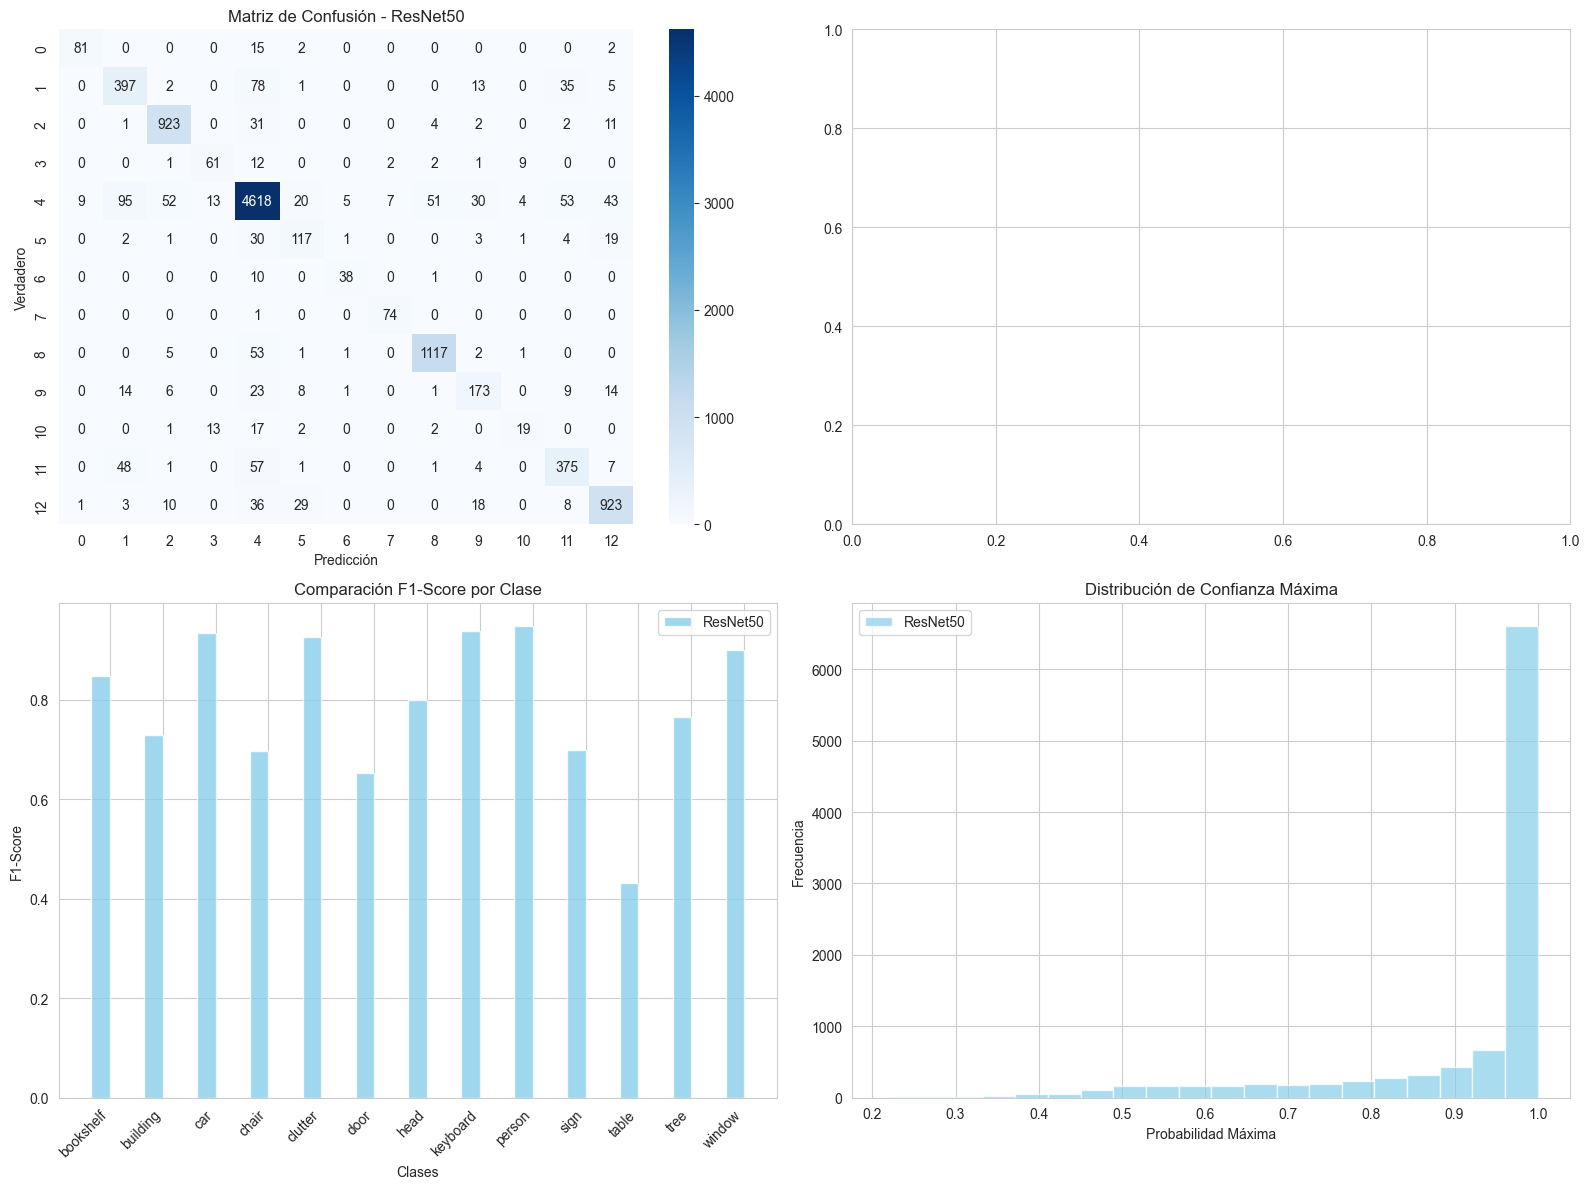


💡 INSIGHTS PRINCIPALES:
  • ResNet50: {'f1_weighted': 0.8912500642592327, 'accuracy': 0.8916, 'balanced_accuracy': np.float64(0.7839813066290487), 'mcc': 0.8473769370016327} accuracy


In [78]:
# Función para análisis detallado
def analyze_results(predictions, probabilities, y_true, model_name):
    """
    Análisis detallado de los resultados del modelo
    """
    print(f"\n📊 Análisis de {model_name}:")
    
    # Reporte de clasificación
    print(f"\n📋 Reporte de Clasificación:")
    report = classification_report(y_true, predictions, output_dict=True)
    
    # Mostrar métricas por clase
    for class_name, metrics in report.items():
        if isinstance(metrics, dict) and 'precision' in metrics:
            print(f"  {class_name:<15}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")
    
    # Métricas generales
    print(f"\n📈 Métricas Generales:")
    print(f"  • Accuracy: {report['accuracy']:.4f}")
    print(f"  • Macro Avg F1: {report['macro avg']['f1-score']:.4f}")
    print(f"  • Weighted Avg F1: {report['weighted avg']['f1-score']:.4f}")
    
    return report

# Analizar resultados de ResNet50
resnet50_report = analyze_results(
    resnet50_predictions, resnet50_probabilities, 
    resnet50_test_df['class'], "ResNet50"
)


# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Matriz de confusión ResNet50
cm_resnet50 = confusion_matrix(resnet50_test_df['class'], resnet50_predictions)
sns.heatmap(cm_resnet50, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión - ResNet50')
axes[0, 0].set_xlabel('Predicción')
axes[0, 0].set_ylabel('Verdadero')

# Comparación de accuracy por clase
class_names = list(resnet50_report.keys())[:-3]  # Excluir métricas generales
resnet50_f1 = [resnet50_report[cls]['f1-score'] for cls in class_names if isinstance(resnet50_report[cls], dict)]

x = np.arange(len(class_names))
width = 0.35

axes[1, 0].bar(x - width/2, resnet50_f1, width, label='ResNet50', color='skyblue', alpha=0.8)
axes[1, 0].set_title('Comparación F1-Score por Clase')
axes[1, 0].set_xlabel('Clases')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].legend()

# Distribución de probabilidades
axes[1, 1].hist(resnet50_probabilities.max(axis=1), bins=20, alpha=0.7, label='ResNet50', color='skyblue')
axes[1, 1].set_title('Distribución de Confianza Máxima')
axes[1, 1].set_xlabel('Probabilidad Máxima')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n💡 INSIGHTS PRINCIPALES:")
print("=" * 25)
print(f"  • ResNet50: {resnet50_accuracy} accuracy")